Last updated: 16 Feb 2023

# 👋 PyCaret Multiclass Classification Tutorial

PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that exponentially speeds up the experiment cycle and makes you more productive.

Compared with the other open-source machine learning libraries, PyCaret is an alternate low-code library that can be used to replace hundreds of lines of code with a few lines only. This makes experiments exponentially fast and efficient. PyCaret is essentially a Python wrapper around several machine learning libraries and frameworks, such as scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, Optuna, Hyperopt, Ray, and a few more.

The design and simplicity of PyCaret are inspired by the emerging role of citizen data scientists, a term first used by Gartner. Citizen Data Scientists are power users who can perform both simple and moderately sophisticated analytical tasks that would previously have required more technical expertise.


In [1]:
import sys
print(sys.version)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]


In [2]:
# check installed version
import pycaret
print(pycaret.__version__)
from pycaret.classification import *

3.3.2


# 🚀 Quick start

PyCaret’s Classification Module is a supervised machine learning module that is used for classifying elements into groups. The goal is to predict the categorical class labels which are discrete and unordered.

Some common use cases include predicting customer default (Yes or No), predicting customer churn (customer will leave or stay), the disease found (positive or negative).

This module can be used for binary or multiclass problems. It provides several pre-processing features that prepare the data for modeling through the setup function. It has over 18 ready-to-use algorithms and several plots to analyze the performance of trained models.

A typical workflow in PyCaret consist of following 5 steps in this order:

## **Setup** ➡️ **Compare Models** ➡️ **Analyze Model** ➡️ **Prediction** ➡️ **Save Model**

In [3]:
# loading sample dataset from pycaret dataset module
csv_path = r"C:\Users\SynLab_BD\Desktop\EEProject\wine+quality\winequality-red.csv"

wine_df = pd.read_csv(csv_path, sep=';')
print("Original shape:", wine_df.shape)
wine_df.head()

Original shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Check for duplicates
print("Number of duplicate rows:", wine_df.duplicated().sum())

# Drop duplicates (as done in Jain et al.)
wine_df = wine_df.drop_duplicates().reset_index(drop=True)
print("Shape after dropping duplicates:", wine_df.shape)

# Create binary quality label:
#  "bad" (0) if quality <= 5
#  "good" (1) if quality > 5
wine_df['quality_binary'] = (wine_df['quality'] > 5).astype(int)
wine_df = wine_df.drop(columns=['quality'])

# Quick check of class balance
print(wine_df['quality_binary'].value_counts())
print(wine_df['quality_binary'].value_counts(normalize=True))

Number of duplicate rows: 240
Shape after dropping duplicates: (1359, 12)
quality_binary
1    719
0    640
Name: count, dtype: int64
quality_binary
1    0.529065
0    0.470935
Name: proportion, dtype: float64


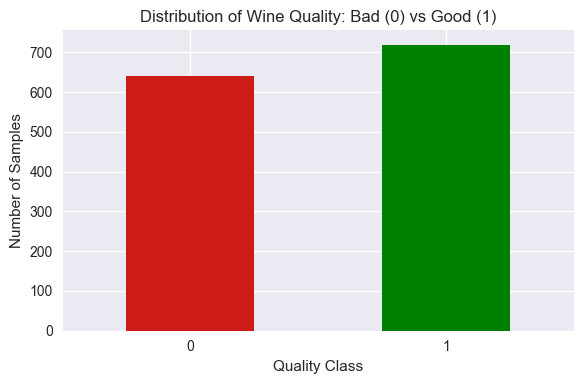

In [5]:
plt.style.use('seaborn')

class_counts = wine_df['quality_binary'].value_counts().sort_index()

plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color=['#CD1C18', '#008000'])

plt.title('Distribution of Wine Quality: Bad (0) vs Good (1)')
plt.xlabel('Quality Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


## Histograms for Features & Correlation Matrix

Numeric columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality_binary']


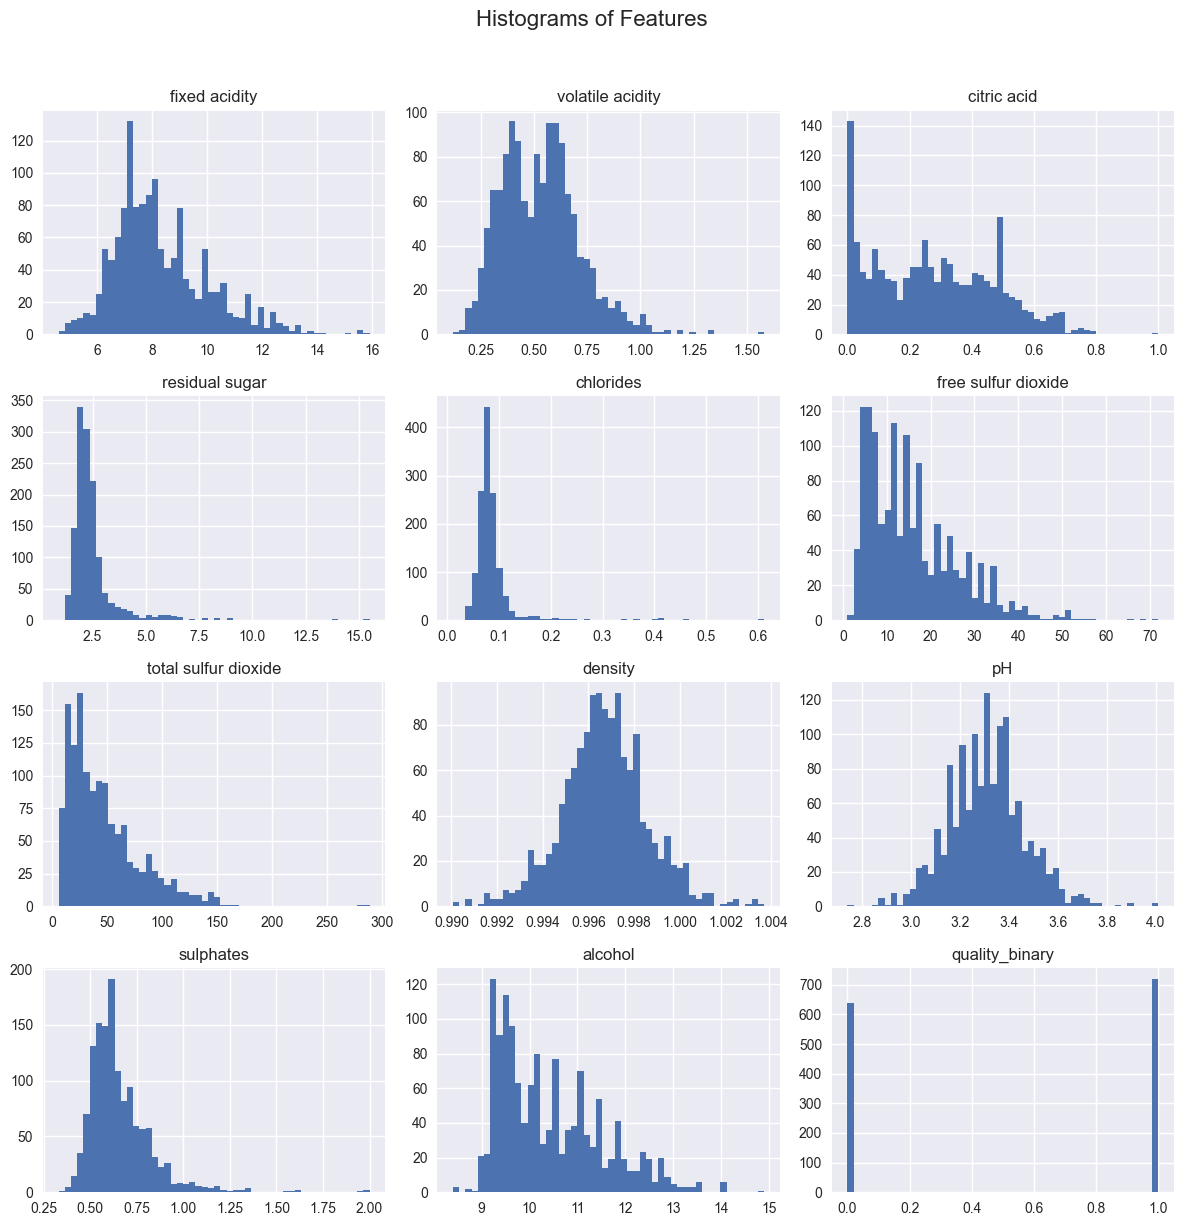

In [6]:
numeric_cols = wine_df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

# Histograms
wine_df[numeric_cols].hist(bins=50, figsize=(12, 12))
plt.suptitle("Histograms of Features", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

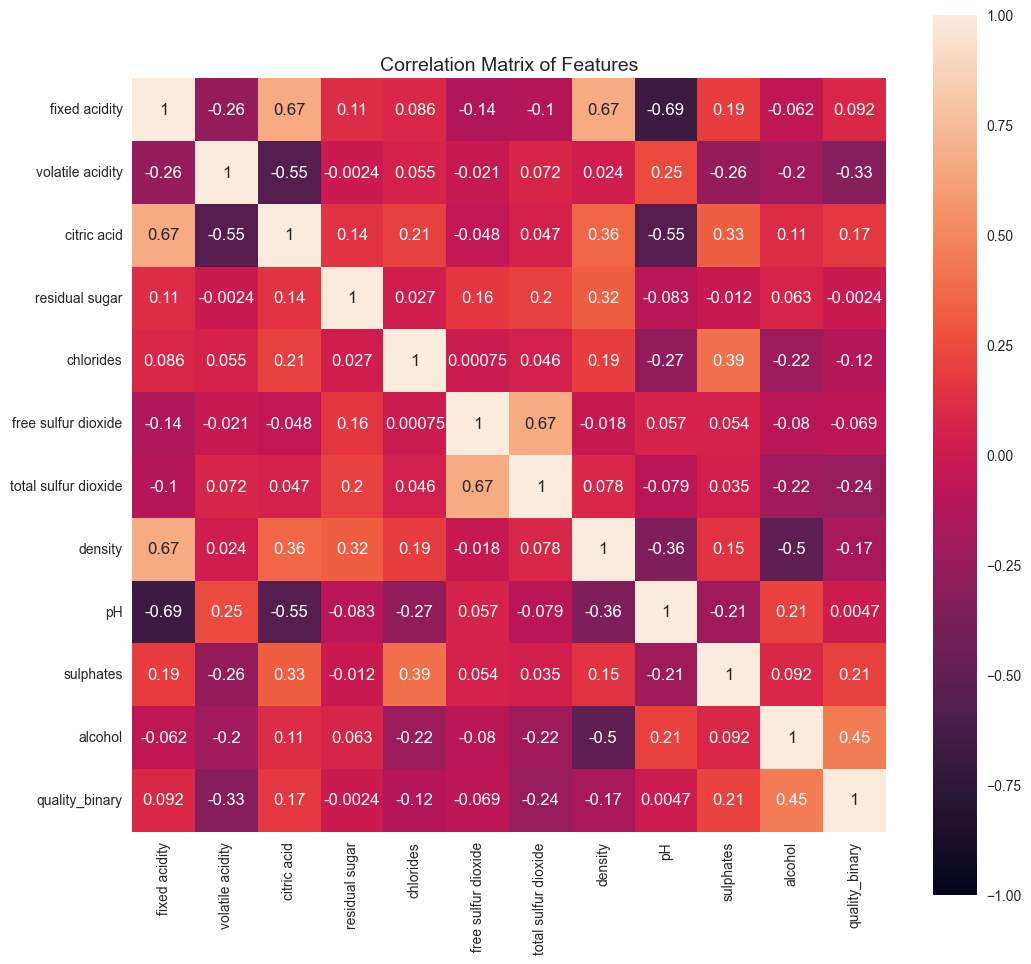

In [7]:
# Correlation Matrix
plt.figure(figsize=(11, 10))
corr = wine_df[numeric_cols].corr()
sns.heatmap(
    corr,
    annot=True,
    vmin=-1,
    vmax=1,
    square=True
)
plt.title("Correlation Matrix of Features", fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
corr_target = corr['quality_binary'].sort_values(ascending=False)
print("Correlation with quality_binary:")
print(corr_target)

Correlation with quality_binary:
quality_binary          1.000000
alcohol                 0.446176
sulphates               0.211365
citric acid             0.167903
fixed acidity           0.091761
pH                      0.004693
residual sugar         -0.002371
free sulfur dioxide    -0.069207
chlorides              -0.115071
density                -0.168958
total sulfur dioxide   -0.235046
volatile acidity       -0.327195
Name: quality_binary, dtype: float64


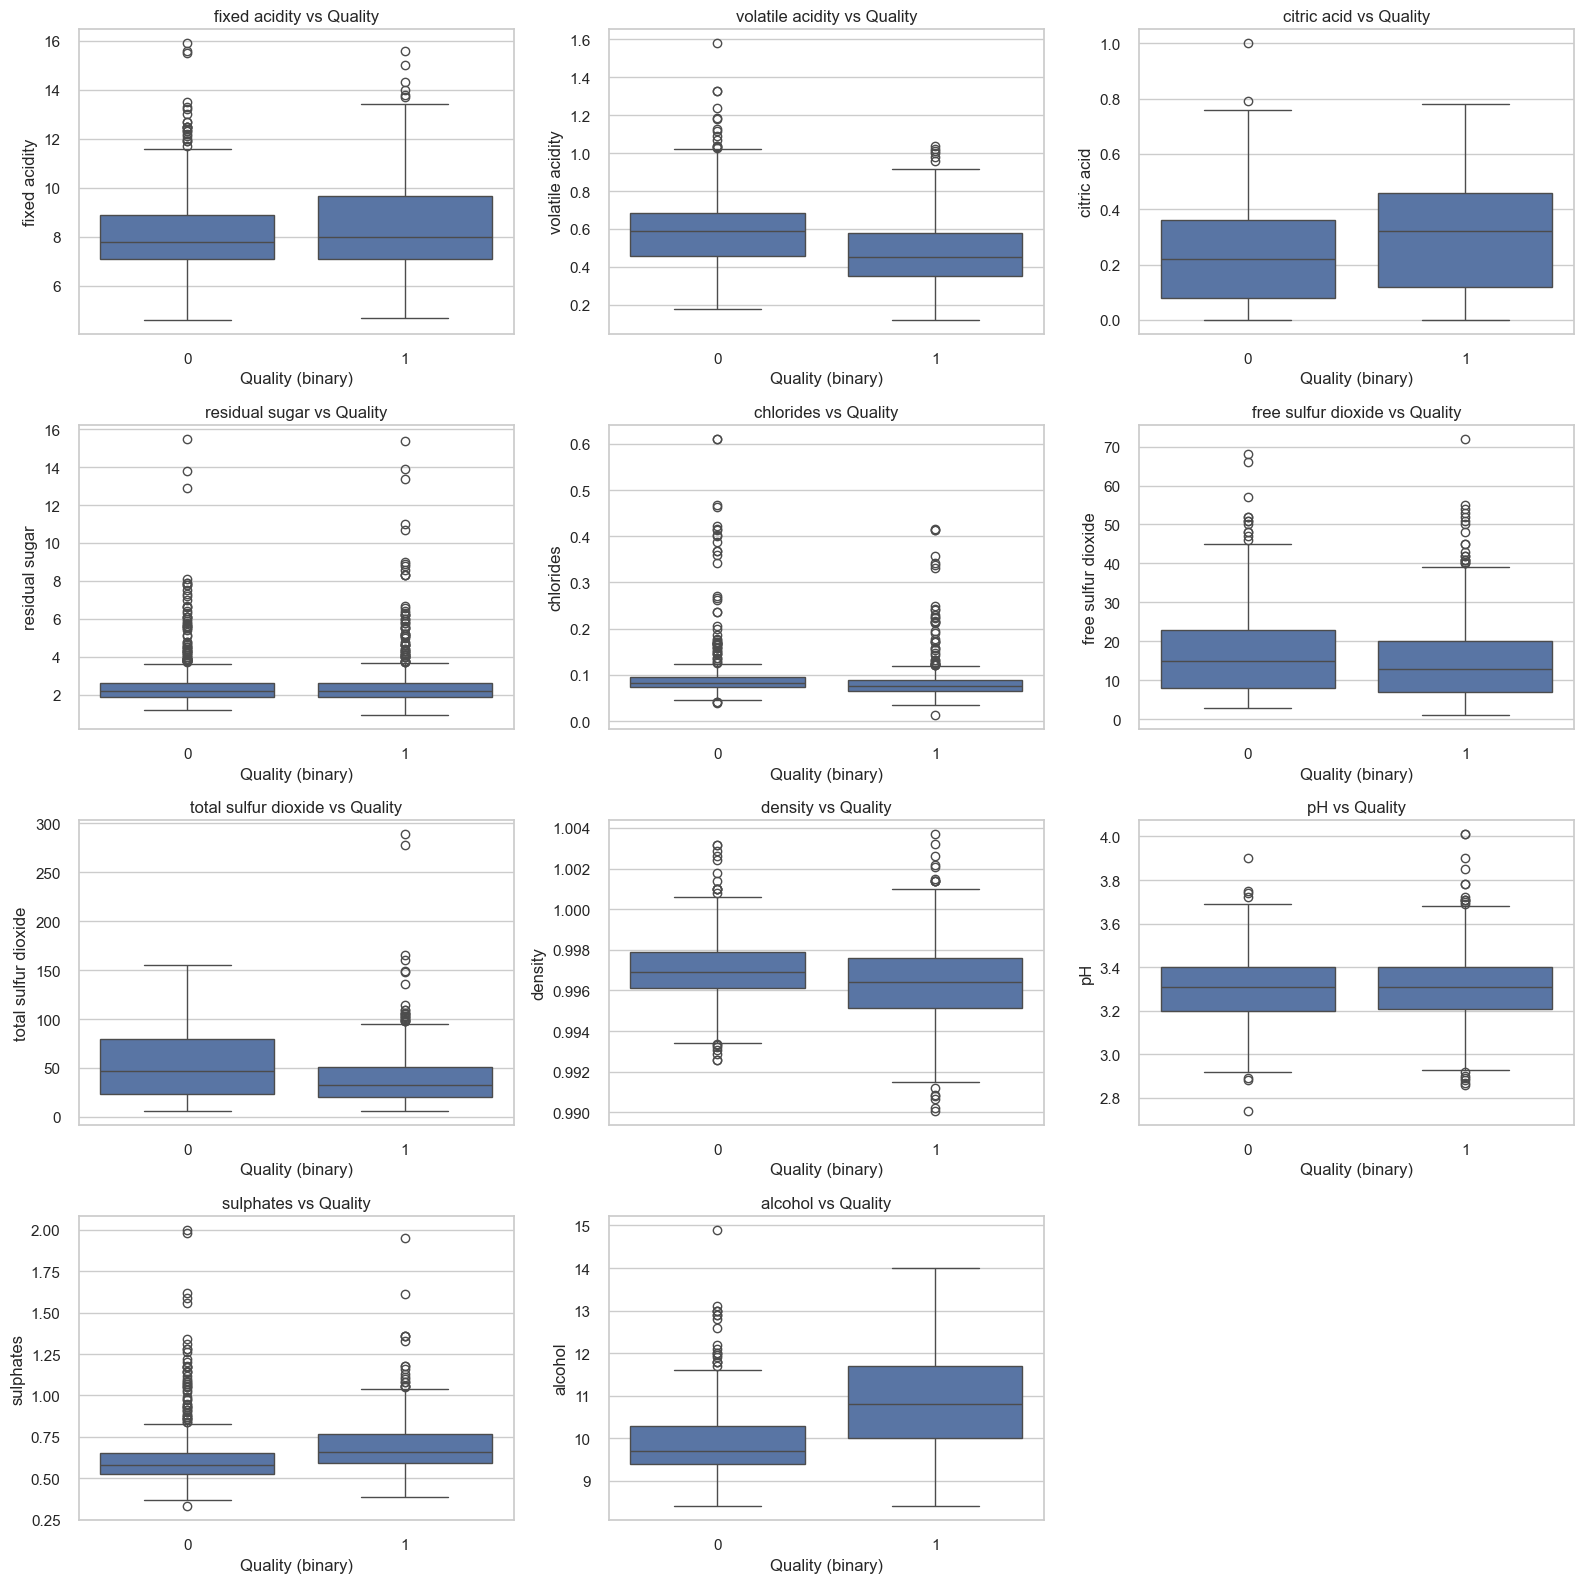

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# list of features (exclude the target)
feature_cols = [col for col in wine_df.columns if col != 'quality_binary']

n_features = len(feature_cols)
n_cols = 3  # 3 plots per row
n_rows = (n_features + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()  # make it easy to index

for i, col in enumerate(feature_cols):
    ax = axes[i]
    sns.boxplot(
        data=wine_df,
        x='quality_binary',
        y=col,
        ax=ax
    )
    ax.set_title(f'{col} vs Quality')
    ax.set_xlabel('Quality (binary)')
    ax.set_ylabel(col)

# hide any unused subplots (if n_features not multiple of n_cols)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Correlation with quality_binary (sorted by absolute value):
quality_binary          1.000000
alcohol                 0.446176
volatile acidity       -0.327195
total sulfur dioxide   -0.235046
sulphates               0.211365
density                -0.168958
citric acid             0.167903
chlorides              -0.115071
fixed acidity           0.091761
free sulfur dioxide    -0.069207
pH                      0.004693
residual sugar         -0.002371
Name: quality_binary, dtype: float64

Top features used for plots: ['alcohol', 'volatile acidity', 'total sulfur dioxide', 'sulphates', 'density', 'citric acid']


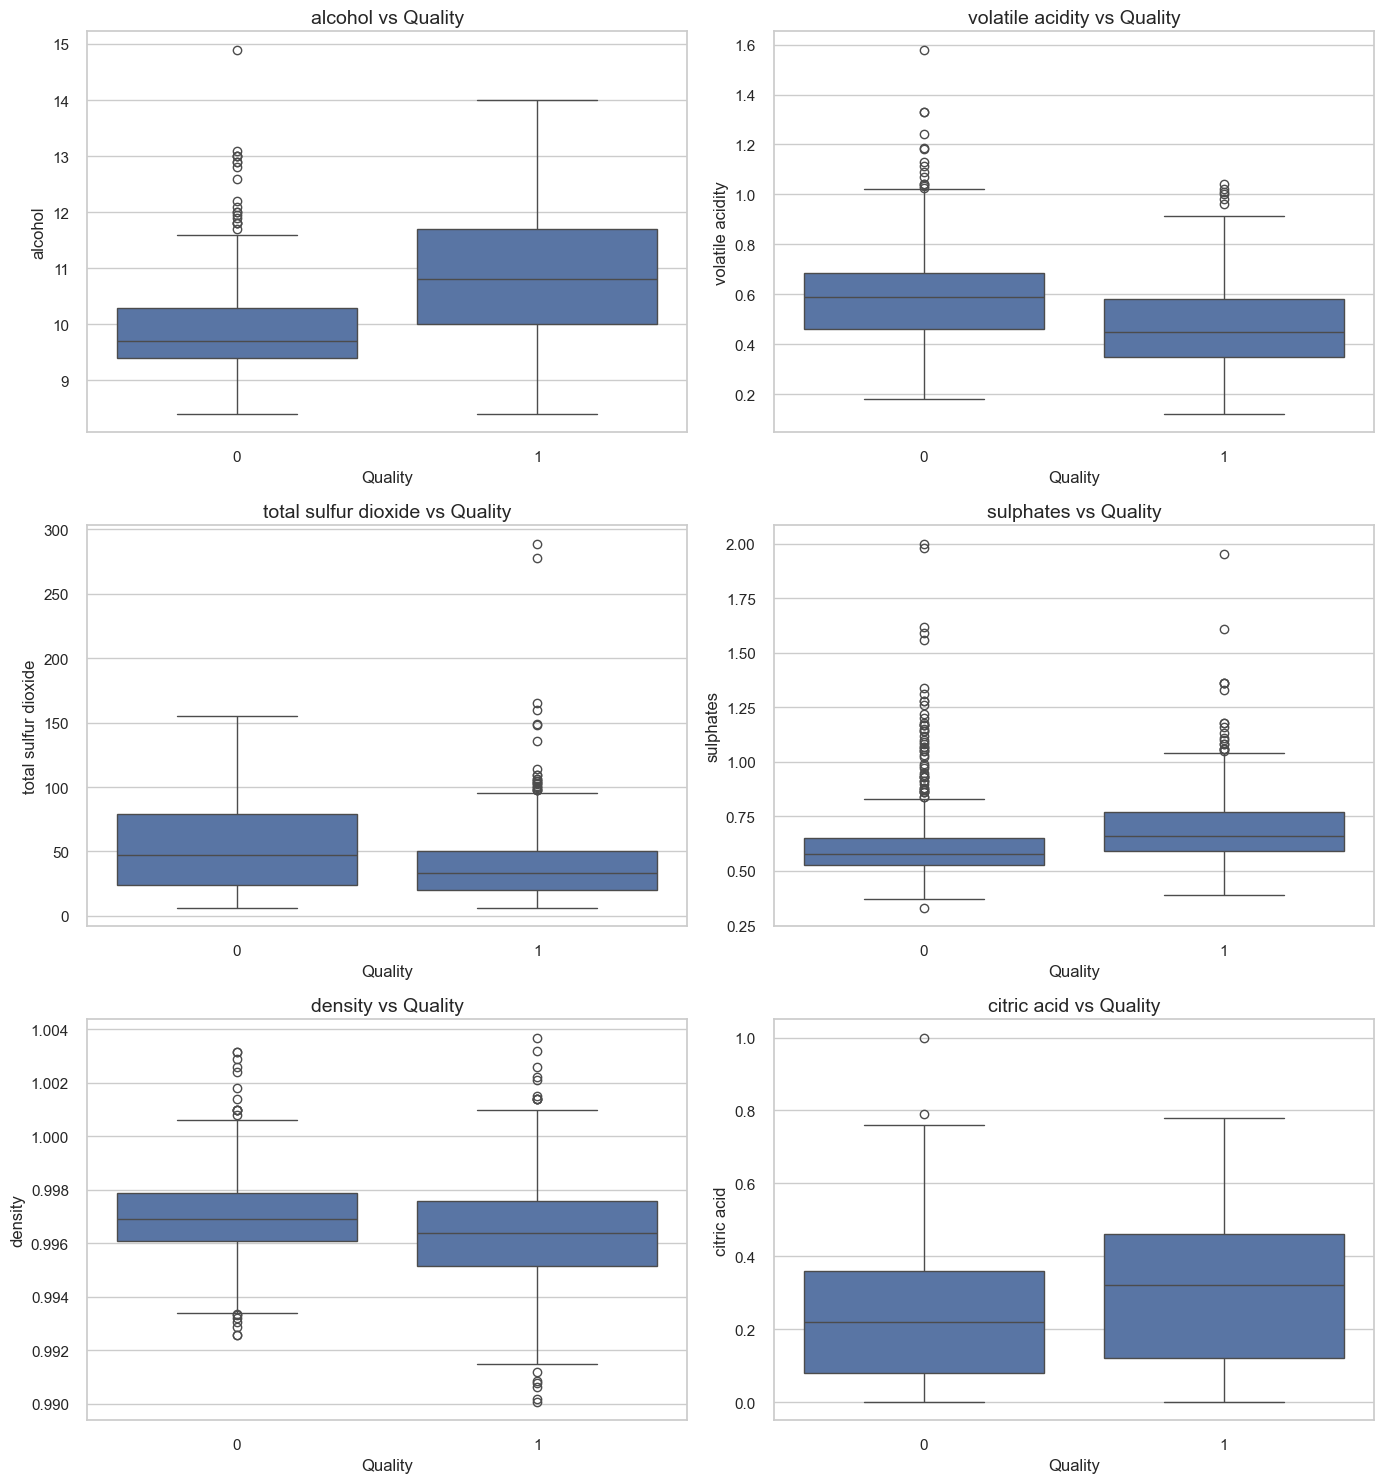

In [10]:
# Correlation with target
corr = wine_df.corr(numeric_only=True)
corr_target = corr['quality_binary']

# Sort by absolute correlation strength
corr_target_sorted = corr_target.reindex(
    corr_target.abs().sort_values(ascending=False).index)

print("Correlation with quality_binary (sorted by absolute value):")
print(corr_target_sorted)

# Pick top features (skip the target itself)
top_features = corr_target_sorted.index.drop('quality_binary')[:6]
print("\nTop features used for plots:", top_features.tolist())

sns.set_theme(style="whitegrid")

n_features = len(top_features)
n_cols = 2
n_rows = (n_features + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(top_features):
    ax = axes[i]
    sns.boxplot(
        data=wine_df,
        x='quality_binary',
        y=col,
        ax=ax
    )
    ax.set_title(f'{col} vs Quality', fontsize=14)
    ax.set_xlabel('Quality')
    ax.set_ylabel(col)

# hide extra axes if grid bigger than needed
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [11]:
def outlier_summary(df, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    summary = []

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        summary.append([
            col,
            len(outliers),
            round(len(outliers) / len(df) * 100, 2),
            round(df[col].min(), 3),
            round(df[col].max(), 3),
            round(lower_bound, 3),
            round(upper_bound, 3),
        ])

    return pd.DataFrame(summary, columns=[
        'Feature',
        'Outlier Count',
        'Outlier %',
        'Min Value',
        'Max Value',
        'Lower Bound',
        'Upper Bound'
    ])

# Run the summary (excluding the target)
outlier_table = outlier_summary(wine_df, exclude_cols=['quality_binary'])
outlier_table

,Feature,Outlier Count,Outlier %,Min Value,Max Value,Lower Bound,Upper Bound
0,fixed acidity,41,3.02,4.600,15.900,3.950,12.350
1,volatile acidity,19,1.40,0.120,1.580,0.015,1.015
2,citric acid,1,0.07,0.000,1.000,-0.420,0.940
3,residual sugar,126,9.27,0.900,15.500,0.850,3.650
4,chlorides,87,6.40,0.012,0.611,0.039,0.122
5,free sulfur dioxide,26,1.91,1.000,72.000,-14.000,42.000
6,total sulfur dioxide,45,3.31,6.000,289.000,-39.500,124.500
7,density,35,2.58,0.990,1.004,0.992,1.001
8,pH,28,2.06,2.740,4.010,2.925,3.685
9,sulphates,55,4.05,0.330,2.000,0.280,1.000


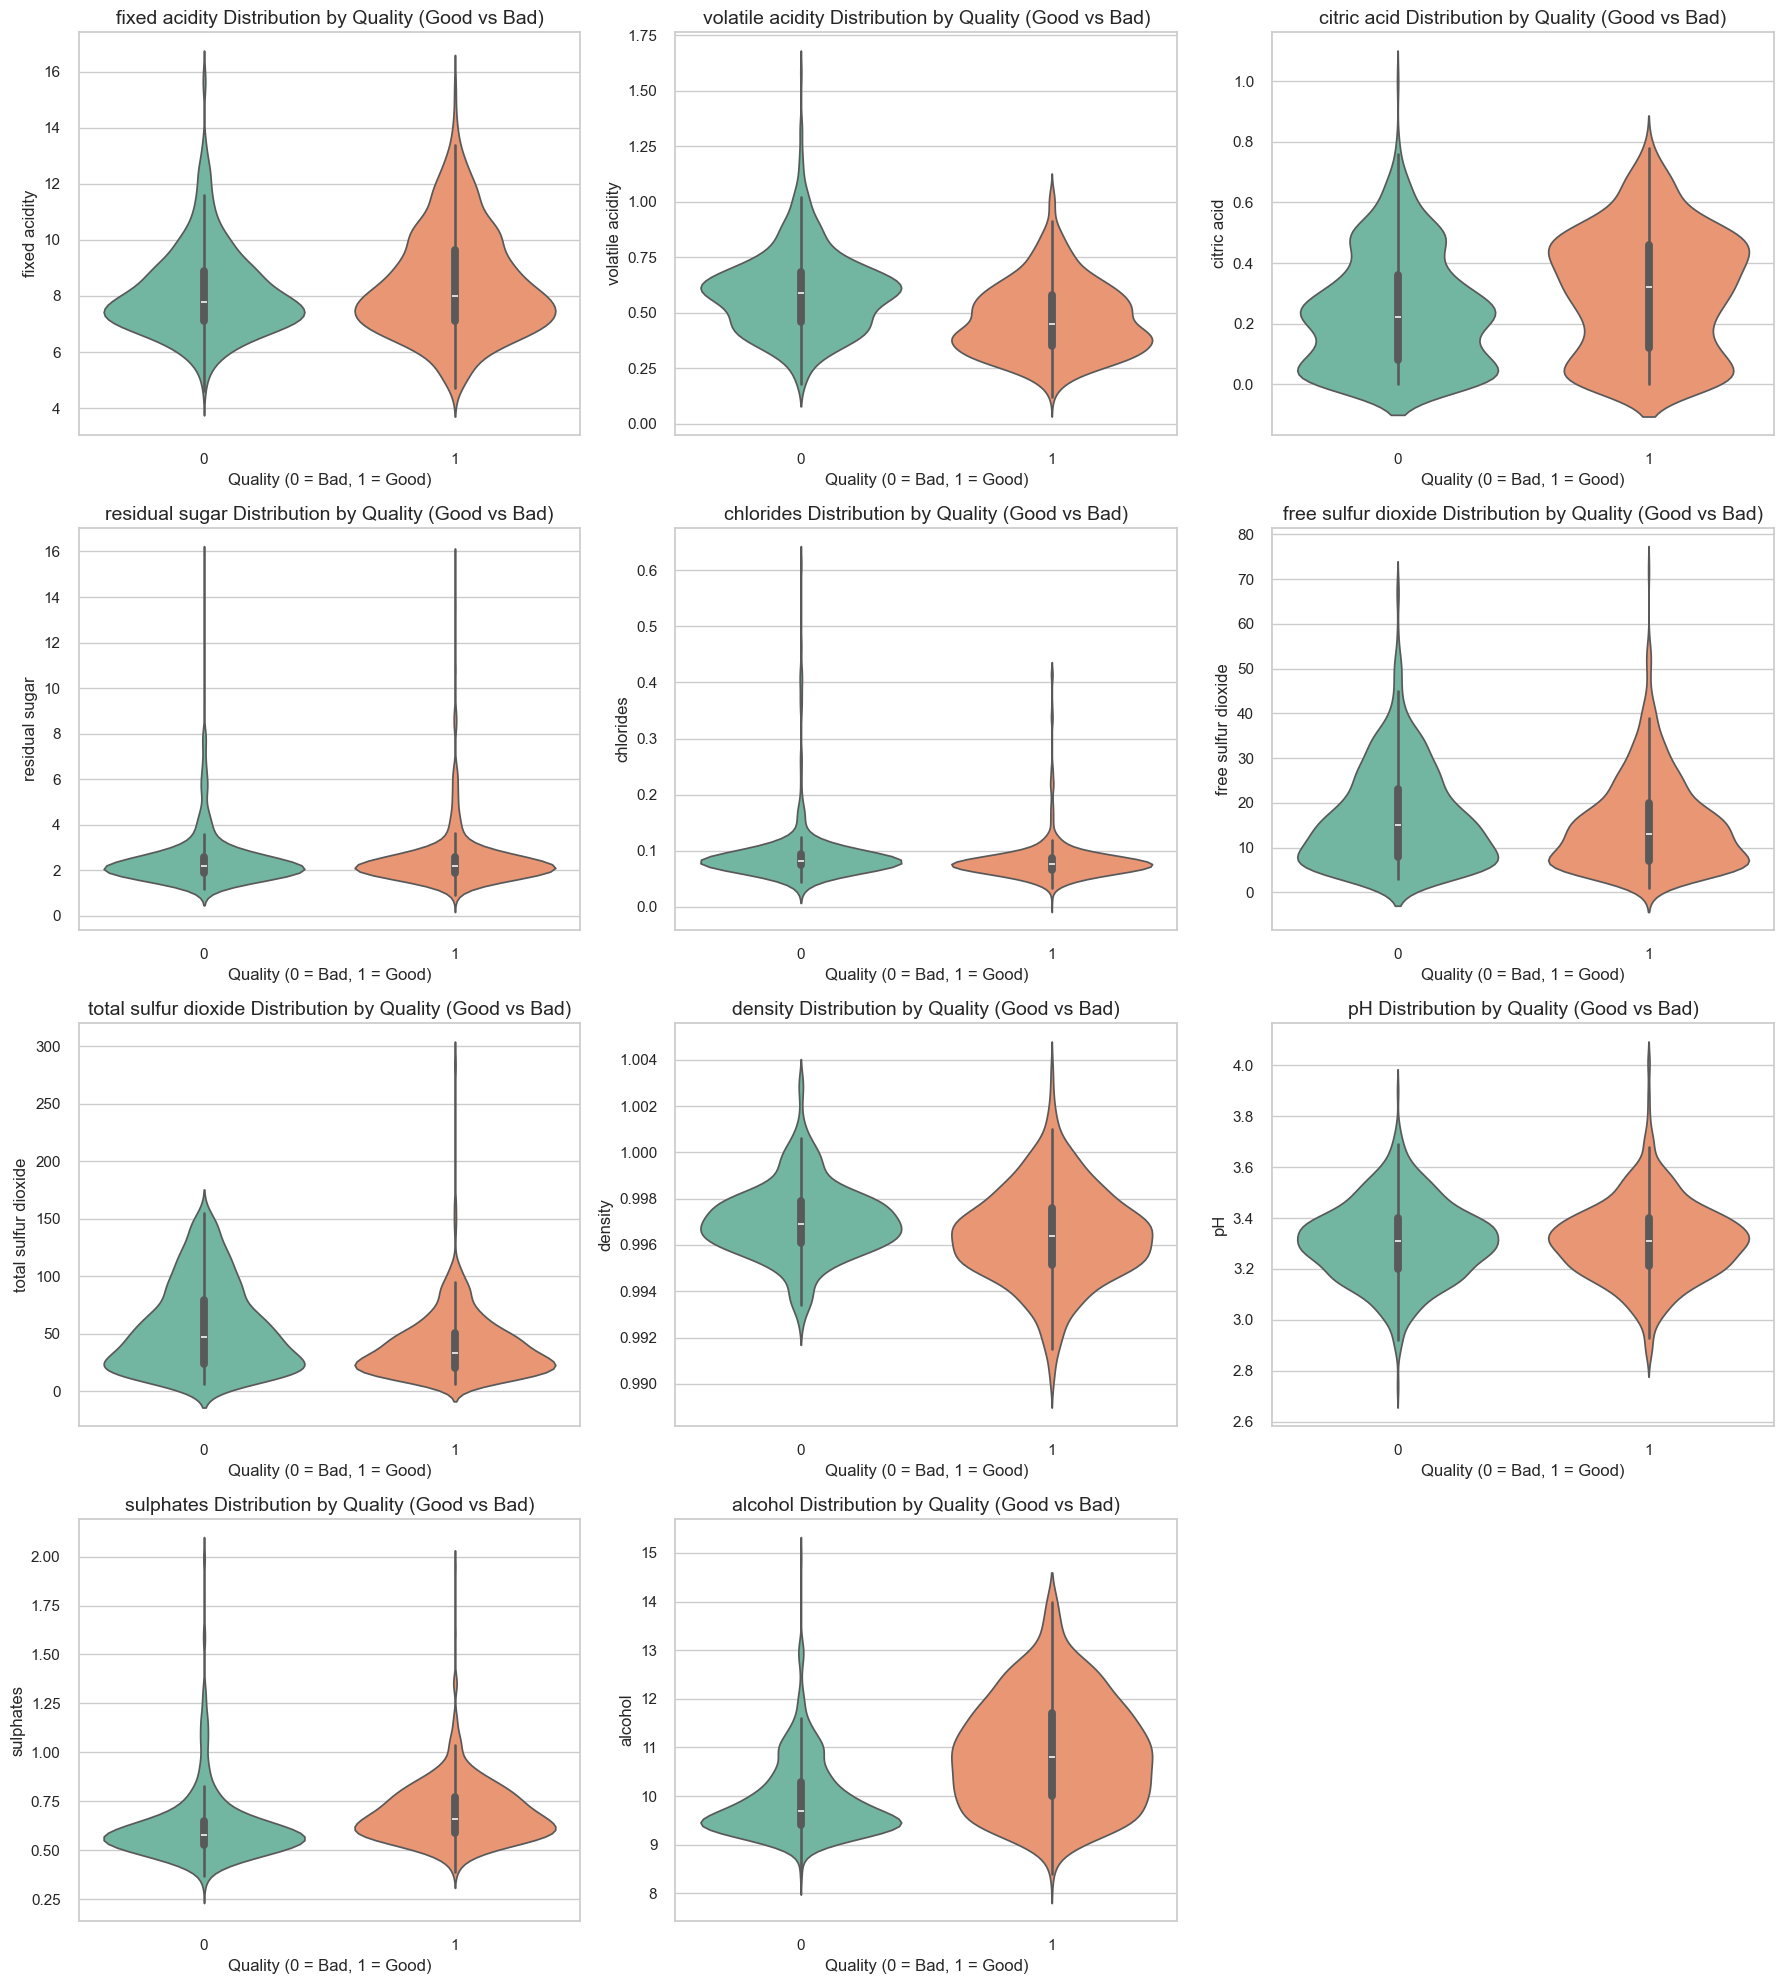

In [12]:
sns.set_theme(style="whitegrid")

# numeric features except the target
numeric_cols = [col for col in wine_df.select_dtypes(include='number').columns 
                if col not in ['quality_binary']]

n_features = len(numeric_cols)
n_cols = 3     # 3 plots per row
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.violinplot(
        data=wine_df,
        x='quality_binary',
        y=col,
        ax=axes[i],
        palette='Set2'
    )
    axes[i].set_title(f'{col} Distribution by Quality (Good vs Bad)', fontsize=14)
    axes[i].set_xlabel('Quality (0 = Bad, 1 = Good)')
    axes[i].set_ylabel(col)

# Hide empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Feature Set Up

In [13]:
data_all = wine_df
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_binary
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0


In [14]:
# For the "feature-engineered" version, following the papers by Jain et al., Niyogisubizo et al.
# Top influential features used: alcohol, sulphates, volatile acidity, chlorides, pH, free sulfur dioxide, fixed acidity, residual sugar.
selected_features = [
    'fixed acidity',
    'volatile acidity',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'pH',
    'sulphates',
    'alcohol',
    'quality_binary'
]

data_reduced = wine_df[selected_features].copy()


In [15]:
print("Shape (all features):", data_all.shape)
print("Shape (selected feature subset):", data_reduced.shape)

Shape (all features): (1359, 12)
Shape (selected feature subset): (1359, 9)


## Setup
This function initializes the training environment and creates the transformation pipeline. Setup function must be called before executing any other function in PyCaret. It only has two required parameters i.e. `data` and `target`. All the other parameters are optional.

## ALL FEATURES with compare_models

In [16]:
exp_all = setup(
    data=data_all,
    target='quality_binary',
    session_id=123,
    train_size=0.8,        # 80/20 split like in the papers
    normalize=True,        # Z-score style scaling (Jain et al. did standardization)
    verbose=True
)

,Description,Value
0,Session id,123
1,Target,quality_binary
2,Target type,Binary
3,Original data shape,"(1359, 12)"
4,Transformed data shape,"(1359, 12)"
5,Transformed train set shape,"(1087, 12)"
6,Transformed test set shape,"(272, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [17]:
# Compare all models by F1-score
best_baseline = compare_models(sort='F1')

baseline_lb = pull()
print(baseline_lb)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7581,0.8277,0.7654,0.7758,0.7694,0.5150,0.5168,0.0900
catboost,CatBoost Classifier,0.7461,0.8283,0.7479,0.7679,0.7563,0.4913,0.4936,1.3250
rf,Random Forest Classifier,0.7434,0.8254,0.7533,0.7612,0.7555,0.4855,0.4880,0.1210
lightgbm,Light Gradient Boosting Machine,0.7415,0.8185,0.7514,0.7600,0.7539,0.4815,0.4840,0.2110
nb,Naive Bayes,0.7295,0.7835,0.7409,0.7465,0.7432,0.4575,0.4583,0.0250
lr,Logistic Regression,0.7304,0.8076,0.7338,0.7509,0.7414,0.4599,0.4611,3.4880
ridge,Ridge Classifier,0.7341,0.8074,0.7234,0.7621,0.7409,0.4682,0.4705,0.0180
lda,Linear Discriminant Analysis,0.7341,0.8074,0.7234,0.7621,0.7409,0.4682,0.4705,0.0180
qda,Quadratic Discriminant Analysis,0.7093,0.7781,0.7863,0.7010,0.7405,0.4124,0.4174,0.0200
ada,Ada Boost Classifier,0.7231,0.8034,0.7426,0.7382,0.7387,0.4440,0.4461,0.0590


                                    Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.7581  0.8277  0.7654  0.7758   
catboost              CatBoost Classifier    0.7461  0.8283  0.7479  0.7679   
rf               Random Forest Classifier    0.7434  0.8254  0.7533  0.7612   
lightgbm  Light Gradient Boosting Machine    0.7415  0.8185  0.7514  0.7600   
nb                            Naive Bayes    0.7295  0.7835  0.7409  0.7465   
lr                    Logistic Regression    0.7304  0.8076  0.7338  0.7509   
ridge                    Ridge Classifier    0.7341  0.8074  0.7234  0.7621   
lda          Linear Discriminant Analysis    0.7341  0.8074  0.7234  0.7621   
qda       Quadratic Discriminant Analysis    0.7093  0.7781  0.7863  0.7010   
ada                  Ada Boost Classifier    0.7231  0.8034  0.7426  0.7382   
xgboost         Extreme Gradient Boosting    0.7259  0.8102  0.7358  0.7453   
gbc          Gradient Boosting Classifier    0.7249 

In [18]:
# baseline ET and RF models
et_base = create_model('et')
rf_base = create_model('rf')

# Store CV results
et_base_results = pull()
print("Baseline Extra Trees:\n", et_base_results)

rf_base_results = create_model('rf')
rf_base_results = pull()
print("Baseline Random Forest:\n", rf_base_results)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6881,0.7546,0.6552,0.7308,0.6909,0.3780,0.3803
1,0.7615,0.8278,0.7931,0.7667,0.7797,0.5198,0.5202
2,0.7982,0.8938,0.7414,0.8600,0.7963,0.5985,0.6049
3,0.7523,0.8387,0.7586,0.7719,0.7652,0.5031,0.5032
4,0.7798,0.8271,0.7759,0.8036,0.7895,0.5589,0.5592
5,0.7431,0.8409,0.7368,0.7636,0.7500,0.4860,0.4864
6,0.7523,0.8335,0.7368,0.7778,0.7568,0.5048,0.5056
7,0.7407,0.8105,0.8246,0.7231,0.7705,0.4755,0.4810
8,0.8333,0.8710,0.8772,0.8197,0.8475,0.6642,0.6661


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6972,0.7632,0.6379,0.7551,0.6916,0.3984,0.4039
1,0.7523,0.8567,0.7586,0.7719,0.7652,0.5031,0.5032
2,0.7523,0.8570,0.6897,0.8163,0.7477,0.5078,0.5148
3,0.7798,0.8568,0.7931,0.7931,0.7931,0.5578,0.5578
4,0.7156,0.8242,0.7586,0.7213,0.7395,0.4268,0.4275
5,0.7064,0.8244,0.7193,0.7193,0.7193,0.4116,0.4116
6,0.7339,0.8389,0.7193,0.7593,0.7387,0.4681,0.4688
7,0.7500,0.8084,0.8596,0.7206,0.7840,0.4927,0.5036
8,0.8148,0.8602,0.8421,0.8136,0.8276,0.6277,0.6282


Baseline Extra Trees:
       Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.6972  0.7632  0.6379  0.7551  0.6916  0.3984  0.4039
1       0.7523  0.8567  0.7586  0.7719  0.7652  0.5031  0.5032
2       0.7523  0.8570  0.6897  0.8163  0.7477  0.5078  0.5148
3       0.7798  0.8568  0.7931  0.7931  0.7931  0.5578  0.5578
4       0.7156  0.8242  0.7586  0.7213  0.7395  0.4268  0.4275
5       0.7064  0.8244  0.7193  0.7193  0.7193  0.4116  0.4116
6       0.7339  0.8389  0.7193  0.7593  0.7387  0.4681  0.4688
7       0.7500  0.8084  0.8596  0.7206  0.7840  0.4927  0.5036
8       0.8148  0.8602  0.8421  0.8136  0.8276  0.6277  0.6282
9       0.7315  0.7640  0.7544  0.7414  0.7478  0.4607  0.4608
Mean    0.7434  0.8254  0.7533  0.7612  0.7555  0.4855  0.4880
Std     0.0334  0.0350  0.0636  0.0351  0.0368  0.0661  0.0659


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6972,0.7632,0.6379,0.7551,0.6916,0.3984,0.4039
1,0.7523,0.8567,0.7586,0.7719,0.7652,0.5031,0.5032
2,0.7523,0.8570,0.6897,0.8163,0.7477,0.5078,0.5148
3,0.7798,0.8568,0.7931,0.7931,0.7931,0.5578,0.5578
4,0.7156,0.8242,0.7586,0.7213,0.7395,0.4268,0.4275
5,0.7064,0.8244,0.7193,0.7193,0.7193,0.4116,0.4116
6,0.7339,0.8389,0.7193,0.7593,0.7387,0.4681,0.4688
7,0.7500,0.8084,0.8596,0.7206,0.7840,0.4927,0.5036
8,0.8148,0.8602,0.8421,0.8136,0.8276,0.6277,0.6282


Baseline Random Forest:
       Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.6972  0.7632  0.6379  0.7551  0.6916  0.3984  0.4039
1       0.7523  0.8567  0.7586  0.7719  0.7652  0.5031  0.5032
2       0.7523  0.8570  0.6897  0.8163  0.7477  0.5078  0.5148
3       0.7798  0.8568  0.7931  0.7931  0.7931  0.5578  0.5578
4       0.7156  0.8242  0.7586  0.7213  0.7395  0.4268  0.4275
5       0.7064  0.8244  0.7193  0.7193  0.7193  0.4116  0.4116
6       0.7339  0.8389  0.7193  0.7593  0.7387  0.4681  0.4688
7       0.7500  0.8084  0.8596  0.7206  0.7840  0.4927  0.5036
8       0.8148  0.8602  0.8421  0.8136  0.8276  0.6277  0.6282
9       0.7315  0.7640  0.7544  0.7414  0.7478  0.4607  0.4608
Mean    0.7434  0.8254  0.7533  0.7612  0.7555  0.4855  0.4880
Std     0.0334  0.0350  0.0636  0.0351  0.0368  0.0661  0.0659


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6881,0.7546,0.6552,0.7308,0.6909,0.3780,0.3803
1,0.7615,0.8278,0.7931,0.7667,0.7797,0.5198,0.5202
2,0.7982,0.8938,0.7414,0.8600,0.7963,0.5985,0.6049
3,0.7523,0.8387,0.7586,0.7719,0.7652,0.5031,0.5032
4,0.7798,0.8271,0.7759,0.8036,0.7895,0.5589,0.5592
5,0.7431,0.8409,0.7368,0.7636,0.7500,0.4860,0.4864
6,0.7523,0.8335,0.7368,0.7778,0.7568,0.5048,0.5056
7,0.7407,0.8105,0.8246,0.7231,0.7705,0.4755,0.4810
8,0.8333,0.8710,0.8772,0.8197,0.8475,0.6642,0.6661


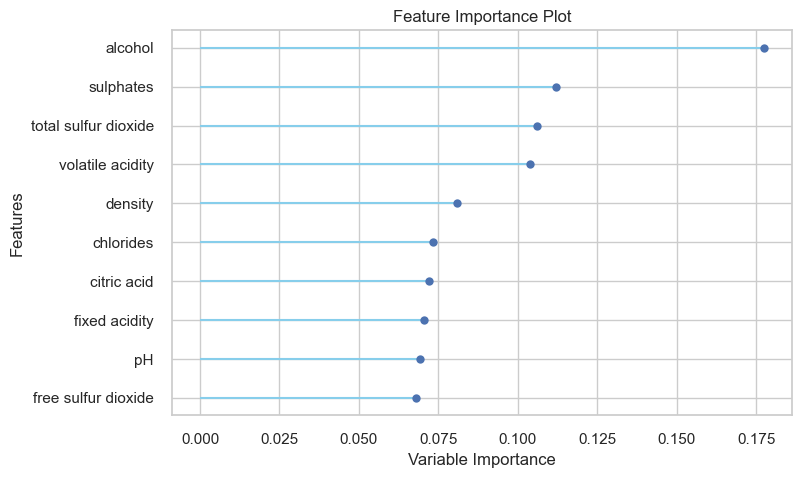

In [19]:
et_base = create_model('et')

plot_model(et_base, plot='feature') 

In [20]:
data_all = data_all.rename(columns=lambda c: c.strip().replace(' ', '_'))
print(data_all.columns)

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality_binary'],
      dtype='object')


In [21]:
#Feature Engineering/Selection by PyCaret/setup

exp2 = setup(
    data=data_all,
    target='quality_binary',
    session_id=123,
    train_size=0.8,
    normalize=True,
    feature_selection=True,              # RFE-style feature selection
    n_features_to_select=0.8,     # keep features that explain 80%+ importance
    #remove_multicollinearity=True,
    #multicollinearity_threshold=0.95,    # drop very highly correlated predictors
    verbose=True
)

# Compare models 
best_fe = compare_models(sort='F1')
fe_lb = pull()
print(fe_lb)


,Description,Value
0,Session id,123
1,Target,quality_binary
2,Target type,Binary
3,Original data shape,"(1359, 12)"
4,Transformed data shape,"(1359, 9)"
5,Transformed train set shape,"(1087, 9)"
6,Transformed test set shape,"(272, 9)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7470,0.8262,0.7687,0.7571,0.7620,0.4920,0.4933,0.2740
xgboost,Extreme Gradient Boosting,0.7415,0.8115,0.7634,0.7520,0.7565,0.4808,0.4825,0.2910
lightgbm,Light Gradient Boosting Machine,0.7406,0.8175,0.7549,0.7551,0.7544,0.4794,0.4802,0.3730
catboost,CatBoost Classifier,0.7424,0.8263,0.7445,0.7633,0.7523,0.4841,0.4862,1.2310
rf,Random Forest Classifier,0.7369,0.8219,0.7392,0.7594,0.7467,0.4730,0.4762,0.2920
ada,Ada Boost Classifier,0.7314,0.8030,0.7513,0.7433,0.7459,0.4609,0.4630,0.2990
nb,Naive Bayes,0.7295,0.7952,0.7496,0.7419,0.7451,0.4570,0.4579,0.1820
lr,Logistic Regression,0.7295,0.8096,0.7251,0.7542,0.7385,0.4585,0.4601,0.2410
gbc,Gradient Boosting Classifier,0.7268,0.8159,0.7306,0.7474,0.7376,0.4528,0.4548,0.3150
qda,Quadratic Discriminant Analysis,0.7121,0.7849,0.7671,0.7109,0.7373,0.4196,0.4222,0.1970


                                    Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.7470  0.8262  0.7687  0.7571   
xgboost         Extreme Gradient Boosting    0.7415  0.8115  0.7634  0.7520   
lightgbm  Light Gradient Boosting Machine    0.7406  0.8175  0.7549  0.7551   
catboost              CatBoost Classifier    0.7424  0.8263  0.7445  0.7633   
rf               Random Forest Classifier    0.7369  0.8219  0.7392  0.7594   
ada                  Ada Boost Classifier    0.7314  0.8030  0.7513  0.7433   
nb                            Naive Bayes    0.7295  0.7952  0.7496  0.7419   
lr                    Logistic Regression    0.7295  0.8096  0.7251  0.7542   
gbc          Gradient Boosting Classifier    0.7268  0.8159  0.7306  0.7474   
qda       Quadratic Discriminant Analysis    0.7121  0.7849  0.7671  0.7109   
ridge                    Ridge Classifier    0.7304  0.8097  0.7129  0.7619   
lda          Linear Discriminant Analysis    0.7304 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6972,0.7617,0.6724,0.7358,0.7027,0.3956,0.3972
1,0.7431,0.8276,0.7414,0.7679,0.7544,0.4853,0.4857
2,0.8165,0.8778,0.7414,0.8958,0.8113,0.6358,0.6466
3,0.7248,0.8409,0.7414,0.7414,0.7414,0.4473,0.4473
4,0.7339,0.8114,0.7586,0.7458,0.7521,0.4651,0.4651
5,0.7431,0.8418,0.7368,0.7636,0.7500,0.4860,0.4864
6,0.7615,0.8370,0.7719,0.7719,0.7719,0.5219,0.5219
7,0.7500,0.7850,0.8246,0.7344,0.7769,0.4948,0.4991
8,0.7963,0.8545,0.8421,0.7869,0.8136,0.5896,0.5913


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6697,0.7718,0.6034,0.7292,0.6604,0.3445,0.3503
1,0.7523,0.8411,0.6897,0.8163,0.7477,0.5078,0.5148
2,0.8165,0.8705,0.7414,0.8958,0.8113,0.6358,0.6466
3,0.7982,0.8813,0.7931,0.8214,0.8070,0.5956,0.5960
4,0.7431,0.8306,0.7241,0.7778,0.7500,0.4865,0.4879
5,0.7339,0.8040,0.7895,0.7258,0.7563,0.4645,0.4665
6,0.6972,0.8003,0.6842,0.7222,0.7027,0.3948,0.3953
7,0.7222,0.8022,0.7719,0.7213,0.7458,0.4404,0.4416
8,0.7963,0.8349,0.8246,0.7966,0.8103,0.5905,0.5909


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

Tuned Extra Trees (feature-engineered / feature-selected):
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.6697  0.7718  0.6034  0.7292  0.6604  0.3445  0.3503
1       0.7523  0.8411  0.6897  0.8163  0.7477  0.5078  0.5148
2       0.8165  0.8705  0.7414  0.8958  0.8113  0.6358  0.6466
3       0.7982  0.8813  0.7931  0.8214  0.8070  0.5956  0.5960
4       0.7431  0.8306  0.7241  0.7778  0.7500  0.4865  0.4879
5       0.7339  0.8040  0.7895  0.7258  0.7563  0.4645  0.4665
6       0.6972  0.8003  0.6842  0.7222  0.7027  0.3948  0.3953
7       0.7222  0.8022  0.7719  0.7213  0.7458  0.4404  0.4416
8       0.7963  0.8349  0.8246  0.7966  0.8103  0.5905  0.5909
9       0.6481  0.7145  0.6491  0.6

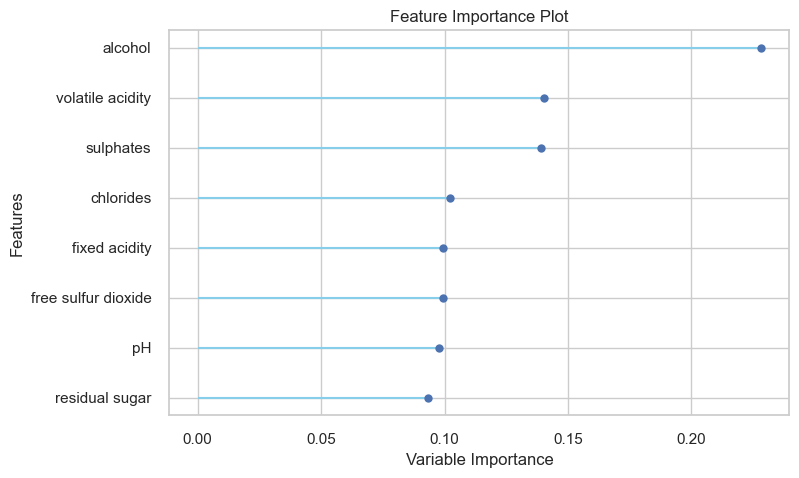

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7647,0.8519,0.8056,0.7632,0.7838,0.5261,0.5271



Final metrics of tuned Extra Trees on holdout set:
                    Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  Extra Trees Classifier    0.7647  0.8519  0.8056  0.7632  0.7838  0.5261   

      MCC  
0  0.5271  


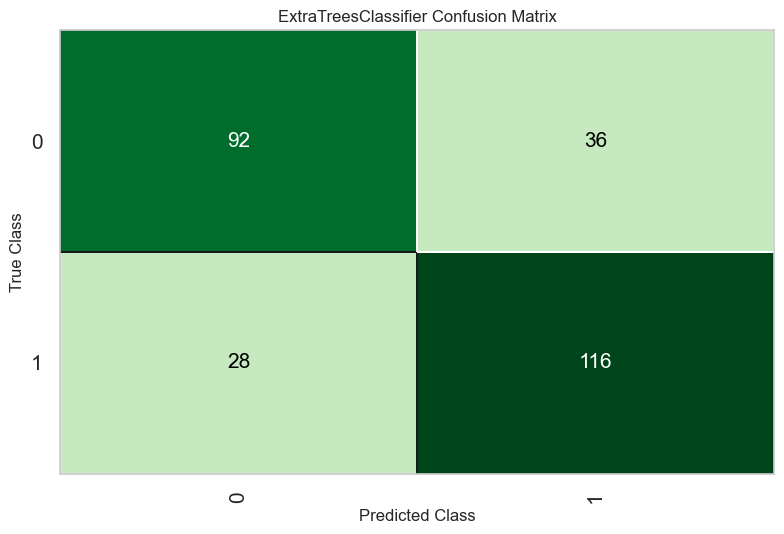

In [27]:
# Hyperparameter tuning on Extra Trees within this feature-selected space
et_fe = create_model('et')
tuned_et = tune_model(et_fe, optimize='F1')
tuned_et_results = pull()
print("\nTuned Extra Trees (feature-engineered/feature-selected):")
print(tuned_et_results)

# Feature importance of tuned Extra Trees
plot_model(tuned_et, plot='feature')

# Evaluate tuned model on holdout set & confusion matrix
et_holdout = predict_model(tuned_et)
final_metrics = pull()
print("\nFinal metrics of tuned Extra Trees on holdout set:")
print(final_metrics)

plot_model(tuned_et, plot='confusion_matrix')

In [28]:
exp_reduced = setup(
    data=data_reduced,
    target='quality_binary',
    session_id=123,
    train_size=0.8,
    normalize=True,
    verbose=True
)

best_reduced = compare_models(sort='F1')
reduced_lb = pull()
print("Leaderboard (8 Feature Subset)")
print(reduced_lb)

et_reduced = create_model('et')
et_holdout_results = predict_model(et_reduced)
et_holdout_metrics = pull()
print("\nExtra Trees on reduced feature set (holdout metrics):")
print(et_holdout_metrics)

,Description,Value
0,Session id,123
1,Target,quality_binary
2,Target type,Binary
3,Original data shape,"(1359, 9)"
4,Transformed data shape,"(1359, 9)"
5,Transformed train set shape,"(1087, 9)"
6,Transformed test set shape,"(272, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7507,0.8227,0.7585,0.7698,0.7629,0.5001,0.5020,0.0840
catboost,CatBoost Classifier,0.7379,0.8171,0.7393,0.7598,0.7483,0.4749,0.4766,1.0840
rf,Random Forest Classifier,0.7286,0.8182,0.7567,0.7381,0.7462,0.4547,0.4565,0.1060
lightgbm,Light Gradient Boosting Machine,0.7240,0.8058,0.7479,0.7361,0.7408,0.4455,0.4471,0.1590
nb,Naive Bayes,0.7240,0.7808,0.7356,0.7417,0.7380,0.4465,0.4474,0.0180
gbc,Gradient Boosting Classifier,0.7249,0.8106,0.7303,0.7443,0.7362,0.4488,0.4500,0.0860
qda,Quadratic Discriminant Analysis,0.7222,0.7789,0.7322,0.7399,0.7355,0.4430,0.4438,0.0200
xgboost,Extreme Gradient Boosting,0.7194,0.7943,0.7375,0.7344,0.7352,0.4368,0.4379,0.1350
lr,Logistic Regression,0.7295,0.8001,0.7113,0.7618,0.7347,0.4596,0.4617,0.0200
ridge,Ridge Classifier,0.7313,0.8010,0.7009,0.7713,0.7334,0.4640,0.4673,0.0190


Leaderboard (8 Feature Subset)
                                    Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.7507  0.8227  0.7585  0.7698   
catboost              CatBoost Classifier    0.7379  0.8171  0.7393  0.7598   
rf               Random Forest Classifier    0.7286  0.8182  0.7567  0.7381   
lightgbm  Light Gradient Boosting Machine    0.7240  0.8058  0.7479  0.7361   
nb                            Naive Bayes    0.7240  0.7808  0.7356  0.7417   
gbc          Gradient Boosting Classifier    0.7249  0.8106  0.7303  0.7443   
qda       Quadratic Discriminant Analysis    0.7222  0.7789  0.7322  0.7399   
xgboost         Extreme Gradient Boosting    0.7194  0.7943  0.7375  0.7344   
lr                    Logistic Regression    0.7295  0.8001  0.7113  0.7618   
ridge                    Ridge Classifier    0.7313  0.8010  0.7009  0.7713   
lda          Linear Discriminant Analysis    0.7313  0.8010  0.7009  0.7713   
ada                  

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6972,0.7617,0.6724,0.7358,0.7027,0.3956,0.3972
1,0.7431,0.8276,0.7414,0.7679,0.7544,0.4853,0.4857
2,0.8165,0.8778,0.7414,0.8958,0.8113,0.6358,0.6466
3,0.7248,0.8409,0.7414,0.7414,0.7414,0.4473,0.4473
4,0.7339,0.8114,0.7586,0.7458,0.7521,0.4651,0.4651
5,0.7431,0.8418,0.7368,0.7636,0.7500,0.4860,0.4864
6,0.7615,0.8370,0.7719,0.7719,0.7719,0.5219,0.5219
7,0.7500,0.7850,0.8246,0.7344,0.7769,0.4948,0.4991
8,0.7963,0.8545,0.8421,0.7869,0.8136,0.5896,0.5913


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7647,0.8519,0.8056,0.7632,0.7838,0.5261,0.5271



Extra Trees on reduced feature set (holdout metrics):
                    Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  Extra Trees Classifier    0.7647  0.8519  0.8056  0.7632  0.7838  0.5261   

      MCC  
0  0.5271  
